In [30]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import torch.nn.functional as F
import torchmetrics

# Define the dataset
class CarDataset(Dataset):
    def __init__(self, images_path, masks_path, transform=None):
        self.images_path = images_path
        self.masks_path = masks_path
        self.transform = transform
        self.images = sorted(os.listdir(images_path))
        self.masks = sorted(os.listdir(masks_path))
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.images_path, self.images[idx])).convert("RGB")
        mask = Image.open(os.path.join(self.masks_path, self.masks[idx]))
        
        if self.transform:
            augmented = self.transform(image=np.array(img), mask=np.array(mask))
            img = augmented['image']
            mask = augmented['mask']
        
        mask = torch.tensor(mask, dtype=torch.long)  # Ensure mask is long type
        return img, mask

# Data augmentation
img_size = (256, 256)  # Define the size to which images will be resized

train_transform = A.Compose([
    A.Resize(*img_size),  # Resize images to the specified size
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=35, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalize images
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(*img_size),  # Resize images to the specified size
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalize images
    ToTensorV2()
])

# Dataset paths
images_path = '/Users/srivantv/Downloads/car-segmentation/images'
masks_path = '/Users/srivantv/Downloads/car-segmentation/masks'

# Load dataset with transformations
full_dataset = CarDataset(images_path, masks_path, transform=None)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)

In [31]:
class SegmentationModel(pl.LightningModule):
    def __init__(self):
        super(SegmentationModel, self).__init__()
        self.model = smp.Unet(encoder_name='resnet34', encoder_weights='imagenet', in_channels=3, classes=5)
        self.loss_fn = torch.nn.CrossEntropyLoss()
        self.metric = torchmetrics.Dice(num_classes=5, average='macro')
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        images, masks = batch
        outputs = self.model(images)
        loss = self.loss_fn(outputs, masks)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        images, masks = batch
        outputs = self.model(images)
        loss = self.loss_fn(outputs, masks)
        outputs = torch.argmax(outputs, dim=1)
        score = self.metric(outputs, masks)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_dice', score, prog_bar=True)
        return {'val_loss': loss, 'val_dice': score}
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [32]:
model = SegmentationModel()

trainer = pl.Trainer(max_epochs=10, accelerator='gpu' if torch.cuda.is_available() else 'cpu', devices=1)
trainer.fit(model, train_loader, val_loader)

# Testing the model on a few images from the validation dataset
model.eval()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Unet             | 24.4 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
2 | metric  | Dice             | 0      | train
-----------------------------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.748    Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/var/folders/9r/flfzkryx2yvgk0hgxphjzvxm0000gn/T/ipykernel_42487/1845901592.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)  # Ensure mask is long type


Training: |                                               | 0/? [00:00<?, ?it/s]

/Users/srivantv/anaconda3/lib/python3.11/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


SegmentationModel(
  (model): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1

/var/folders/9r/flfzkryx2yvgk0hgxphjzvxm0000gn/T/ipykernel_42487/1845901592.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)  # Ensure mask is long type


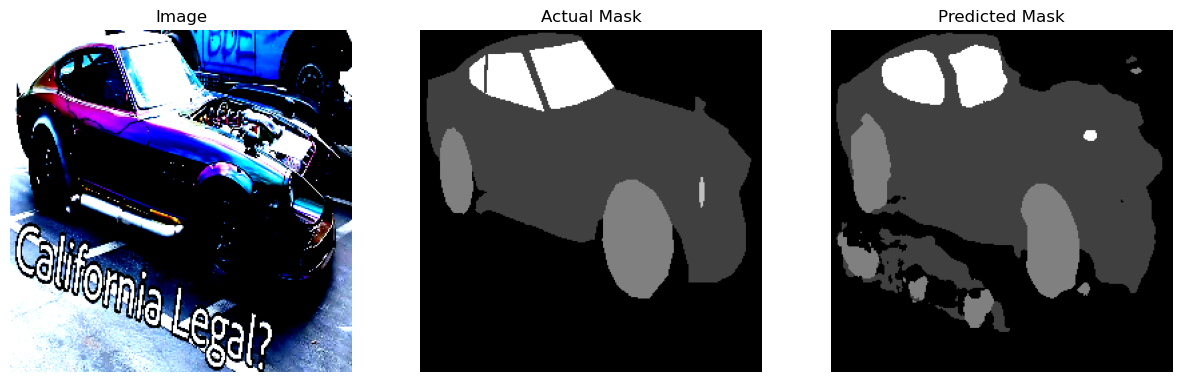

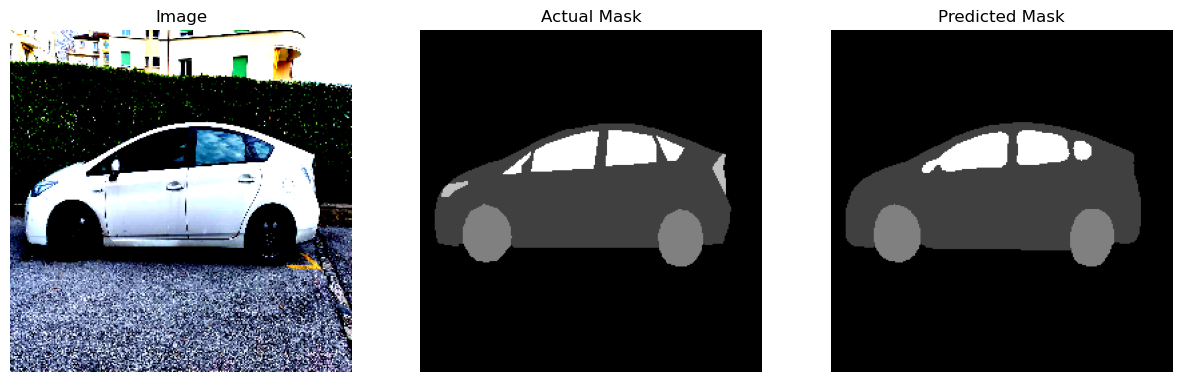

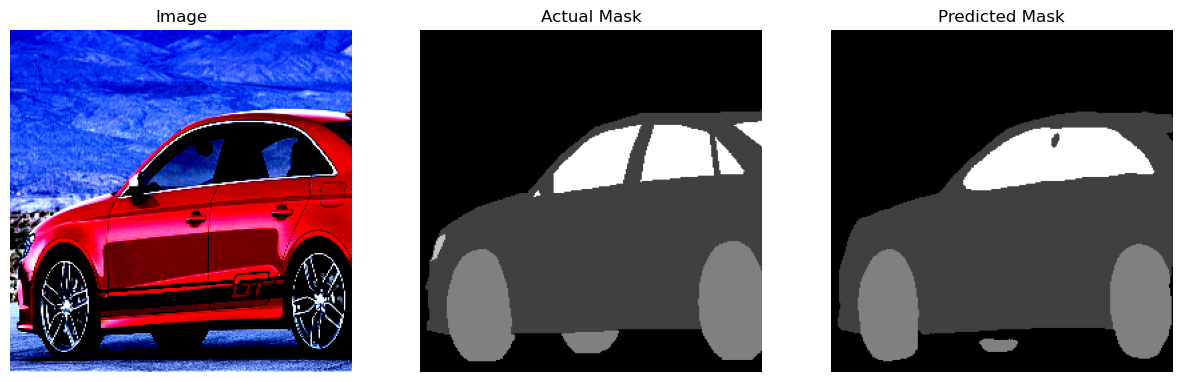

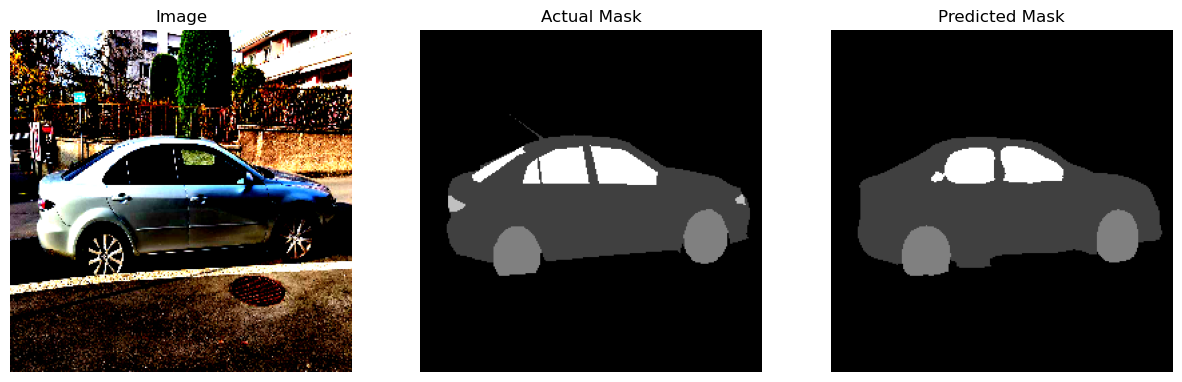

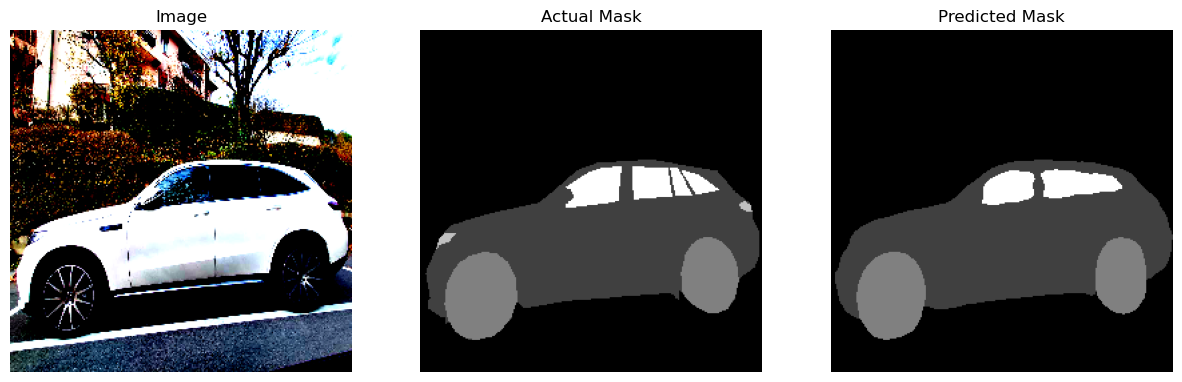

Average Dice Score on test images: 0.7403950452804565


In [36]:
test_dataset, _ = random_split(val_dataset, [5, len(val_dataset) - 5])  # Use a few images for testing
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

def visualize_predictions(images, masks, outputs, idx):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(images.cpu().permute(1, 2, 0))
    axs[0].set_title('Image')
    axs[1].imshow(masks.cpu(), cmap='gray')
    axs[1].set_title('Actual Mask')
    axs[2].imshow(outputs.cpu(), cmap='gray')
    axs[2].set_title('Predicted Mask')
    for ax in axs:
        ax.axis('off')
    plt.savefig(f'prediction_{idx}.png')
    plt.show()


dice_scores = []
for idx, (images, masks) in enumerate(test_loader):
    images = images.to(model.device)
    masks = masks.to(model.device)
    
    with torch.no_grad():
        outputs = model(images)
        outputs = torch.argmax(outputs, dim=1)
        dice_score = torchmetrics.functional.dice(outputs, masks, num_classes=5, average='macro')
        dice_scores.append(dice_score.item())
        visualize_predictions(images[0], masks[0], outputs[0], idx)

# Calculate and print the average Dice score
average_dice_score = np.mean(dice_scores)
print(f'Average Dice Score on test images: {average_dice_score}')